<a href="https://colab.research.google.com/github/enVives/Caltech101/blob/main/Caltech101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [900]:
from itertools import filterfalse
from collections import OrderedDict
import torch,torchvision
import numpy as np
import pandas as pd
import math
import cv2
import time
import os
import wandb
import pylab as pl
import scipy.io
import matplotlib.pyplot as plt


from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from torchvision import transforms,models
from torch import nn
from IPython.display import clear_output,display
from torch.utils.data import DataLoader, random_split,Subset,Dataset
from google.colab.patches import cv2_imshow
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from glob import glob

ROOT = './sample_data/'
CLASS_A = 'cougar_body'
CLASS_B = 'windsor_chair'

DOWNLOAD = False
wandb.login()
#471be466c8949671a46c67e7aad0d5a0ac8c9dad
#!rm -rf /content/sample_data/*
# torch.cuda.default_stream(torch.device('cuda'))

True

In [901]:
def find_mean_std(dataset):
  dataloader = DataLoader(dataset,batch_size = 1,shuffle=FALSE)
  mean = torch.zeros(3)
  std = torch.zeros(3)
  samples = 0

  for image,_ in dataloader:
    mean += image.mean(dim=[0, 2, 3])  # Mean for each channel [batchsize,channels,height,width]
    std += image.std(dim=[0, 2, 3])    # Std for each channel
    samples += 1

  mean /= samples
  std /= samples

  print(mean)
  print(std)

In [902]:
from pickle import NONE

class Formes(Dataset):
    def __init__(self, paths, labels= None, transforms = None,annotations = None,transform_mask = None):
        self.images = paths
        self.labels = labels
        self.transforms = transforms
        self.annotations = annotations
        self.transforms_mask = transform_mask

    def __len__(self):
        return len(self.labels)

    def __setmodel__(self,model):
        self.model = model

    def __getdist__(self):
      return pd.Series(self.labels).value_counts()

    def __showcontours__(self,index):
      path = self.images[index]
      image = cv2.imread(path, cv2.IMREAD_COLOR)
      image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      plt.imshow(image)

      mat_data = scipy.io.loadmat(self.annotations[index])
        #print("Keys in MAT file:", polygons_data.keys())

      polygons_data = mat_data['obj_contour']

      x_points = polygons_data[0]
      y_points = polygons_data[1]

      contour_points = np.array(list(zip(x_points,y_points)))

      plt.plot(contour_points[:, 0], contour_points[:, 1], '-r')  # Red contour line
      plt.scatter(contour_points[:, 0], contour_points[:, 1], c='blue')  # Optional: Mark contour points
      plt.show()

    def __getpureimage__(self,index):
      path = self.images[index]
      image = cv2.imread(path, cv2.IMREAD_COLOR)
      image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      return image

    def __getitem__(self, index):
      path = self.images[index]
      label = self.labels[index]

      seed = torch.random.seed()  # Create a unique seed for random operations

      if self.annotations != None:
        mat_data = scipy.io.loadmat(self.annotations[index])
        #print("Keys in MAT file:", polygons_data.keys())

        polygons_data = mat_data['obj_contour']
        boundingbox_data = mat_data['box_coord']

        x_points = polygons_data[0]
        y_points = polygons_data[1]

        contour_points = list(zip(x_points,y_points))
        contour = np.array(contour_points, dtype=np.int32)

        #print(contour_points)


      image = cv2.imread(path, cv2.IMREAD_COLOR)
      image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      if self.model == 3:
        mask = np.zeros(image.size, dtype=np.uint8)
        cv2.fillPoly(mask, [contour], color=255)  # White filled polygon
        mask = Image.fromarray(mask)  # Convert NumPy array to PIL Image

        torch.random.manual_seed(seed)  # Set seed for image
        mask_resized = self.transforms_mask(mask)
        mask_resized = (mask_resized > 0.5).float()

        torch.random.manual_seed(seed)  # Set seed for image
        image = self.transforms(image)

        return image, mask_resized

      image = self.transforms(image)

      return image, label

In [903]:
def get_labels(sett):
  labels = np.array([])
  frequency = np.zeros(101)
  for _,label in sett:
    labels = np.append(labels,label)
    frequency[label] += 1
  return labels.astype(int),frequency

In [904]:
#from pickle import FALSE
from sklearn.model_selection import train_test_split

TRAINING = 0.80
VAL = 0.10
TESTING = 0.10

#[0.5459, 0.5288, 0.5022]
#[0.2424, 0.2393, 0.2409]
mean = torch.tensor([0.485,0.456,0.406])
std = torch.tensor([0.229,0.224,0.225])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

transform_masks = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(p=0.1),
    # transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
])


transform2 = transforms.Compose([
    #transforms.Lambda(lambda img: img.convert("RGB") if img.mode != "RGB" else img),  # Ensure all images are RGB
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(p=0.1),
    # transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dataset = torchvision.datasets.Caltech101(root= ROOT,download=DOWNLOAD,transform=transform)
img_class_1 = sorted(glob('/content/sample_data/caltech101/101_ObjectCategories/cougar_body/*'))
img_class_2 = sorted(glob('/content/sample_data/caltech101/101_ObjectCategories/windsor_chair/*'))

img_annotations_class_1 = sorted(glob('/content/sample_data/caltech101/Annotations/cougar_body/*'))
img_annotations_class_2 = sorted(glob('/content/sample_data/caltech101/Annotations/windsor_chair/*'))


img_files = img_class_1 +  img_class_2
img_annotations = img_annotations_class_1 + img_annotations_class_2

img_files_duplicated = img_files + img_files  # Duplicate image paths
img_annotations_duplicated = img_annotations + img_annotations  # Duplicate annotation paths

img_files = img_files_duplicated
img_annotations = img_annotations_duplicated

labels = []
for img_path in img_files:
  label = img_path.split(os.path.sep)[-2]
  labels.append(label)

lb = LabelEncoder()
labels = lb.fit_transform(labels)

weights = 1.0 / pd.Series(labels).value_counts()
weights = weights / weights.sum()
weights = torch.tensor(weights,dtype=torch.float32)

X_train, X_test, y_train, y_test, annotations_train, annotations_test = train_test_split(
    img_files, labels, img_annotations, test_size=TESTING, random_state=42, stratify=labels
)

# Split the training set further into training and validation sets
X_train, X_val, y_train, y_val, annotations_train, annotations_val = train_test_split(
    X_train, y_train, annotations_train, test_size=VAL/(TRAINING+VAL), random_state=42, stratify=y_train
)

training = Formes(X_train,y_train,transform2,annotations_train,transform_masks)
testing = Formes(X_test,y_test,transform,annotations_test,transform_masks)
validation = Formes(X_val,y_val,transform,annotations_val,transform_masks)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#training,validation,testing = random_split(dataset,[train_size,validation_size,len(dataset)-train_size-validation_size])

In [905]:
print(f"LONGITUD SET DE TRAINING: {training.__len__()}")
with open("training.txt", "w") as file:
    for item in training.__getdist__()/training.__len__():
        file.write(f"{item}\n")
print(f"LONGITUD SET DE VALIDATION: {validation.__len__()}")
with open("valid.txt", "w") as file:
    for item in validation.__getdist__()/validation.__len__():
        file.write(f"{item}\n")
print(f"LONGITUD SET DE TESTING: {testing.__len__()}")

LONGITUD SET DE TRAINING: 164
LONGITUD SET DE VALIDATION: 21
LONGITUD SET DE TESTING: 21


Ara ja sabem que hem de predir si una imatge pertany a les classes 25 o 99

In [906]:
def veure_imatges(train_data,std,mean):
  for i in range(len(train_data)):
    imatge,label = train_data[i]

    print(imatge.ndimension())
    print(imatge.shape)

    imatge = imatge * (std[:, None, None]*255) + (mean[:, None, None]*255)
    # Convert the tensor back to a NumPy array
    img_numpy = imatge.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    cv2_imshow(img_numpy)
    time.sleep(5)
    clear_output(wait=True)

In [907]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features

        ## CODER
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        ## DECODER

        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2,
                                          stride=2)  # Empra aquesta capa com exemple
        self.decoder4 = UNet._block(features * 16, features * 8, name="dec4")

        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = UNet._block(features * 8, features * 4, name="dec3")

        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = UNet._block(features * 4, features * 2, name="dec2")

        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.final = nn.Conv2d(
            in_channels=features,
            out_channels=out_channels,
            kernel_size=1,
            padding=0,
            bias=False,
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec1 = self.upconv4(bottleneck)
        dec1 = torch.cat((dec1, enc4), dim=1)
        dec2 = self.decoder4(dec1)

        dec2 = self.upconv3(dec2)
        dec2 = torch.cat((dec2, enc3), dim=1)
        dec3 = self.decoder3(dec2)

        dec3 = self.upconv2(dec3)
        dec3 = torch.cat((dec3, enc2), dim=1)
        dec4 = self.decoder2(dec3)

        dec4 = self.upconv1(dec4)
        dec4 = torch.cat((dec4, enc1), dim=1)
        dec5 = self.decoder1(dec4)
        return torch.sigmoid(self.final(dec5))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (name + "conv1",
                     nn.Conv2d(
                         in_channels=in_channels,
                         out_channels=features,
                         kernel_size=3,
                         padding=1,
                         bias=False,
                     ),
                     ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (name + "conv2",
                     nn.Conv2d(
                         in_channels=features,
                         out_channels=features,
                         kernel_size=3,
                         padding=1,
                         bias=False,
                     ),
                     ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [908]:
class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 0.0

    def forward(self, y_pred, y_true):
        # print(y_pred)
        # print(y_true)
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
                y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc

In [909]:
def pick_algorithm(number):
  if number == 0:
    alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1) #fine tuning
    # Modify the classifier
    alexnet.classifier[6] = nn.Linear(in_features=4096, out_features=1)

    # alexnetmulticlass.classifier = nn.Sequential(
    # torch.nn.Dropout(p=0.1),
    # torch.nn.Linear(9216, 2048),
    # nn.ReLU(inplace=True),
    # torch.nn.Linear(2048, 1024),
    # nn.ReLU(inplace=True),
    # torch.nn.Linear(1024, 512),
    # nn.ReLU(inplace=True),
    # torch.nn.Linear(512, 1),  # Ja que tenim 10 classes.
    # )

    loss_fn = nn.BCEWithLogitsLoss()
    #loss_fn = nn.CrossEntropyLoss(weight=weights.to(device))
    return alexnet,loss_fn
  elif number == 1:
    vgg = models.vgg16(weights = models.VGG16_Weights.IMAGENET1K_V1)
    vgg.classifier[6] = nn.Linear(in_features=4096, out_features=1)

    loss_fn = nn.BCEWithLogitsLoss()
    return vgg,loss_fn
  elif number == 2:
    resnet = models.resnet18(weights="IMAGENET1K_V1")
    resnet.classifier[6] = nn.Linear(in_features=4096, out_features=1)
    loss_fn = nn.BCEWithLogitsLoss()

    return resnet,loss_fn
  elif number == 3:
    unet = UNet(3,1)
    loss_fn = DiceLoss()
    return unet,loss_fn

In [910]:
BATCH_SIZE = 8
EPOCHS = 70
PATIENCE = 30

architectures = {'alexnet': 0,'vgg': 1,'resnet': 2,'unet':3}

MODEL = architectures['unet']

training.__setmodel__(MODEL)
validation.__setmodel__(MODEL)
testing.__setmodel__(MODEL)

train_loader = torch.utils.data.DataLoader(training, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation, batch_size=validation.__len__(), shuffle=True)
testing_loader = torch.utils.data.DataLoader(testing, batch_size=testing.__len__(), shuffle=True)

model,loss_fn = pick_algorithm(MODEL)
model.to(device)

learning_rate = 0.00015
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

wandb.init(
        project="caltech101-proves",
        config={
            "epochs": 20,
            "batch_size": BATCH_SIZE,
            "lr": learning_rate,
            "tsize":TRAINING,
            "vsize":VAL,
            "weights": True
            })


config = wandb.config

test_target = None
test_output = None

#veure_imatges(training,std,mean)

In [911]:
img, target= next(iter(train_loader))
print(img.shape)

torch.Size([8, 3, 224, 224])


In [912]:
def fit(model,loss_fn,dataloader,optimizer,epoch,config):

  batch_num = 1
  train_loss = 0
  train_acc = 0
  train_f1 = 0
  train_recall = 0
  train_precision = 0

  n_steps_per_epoch = math.ceil(len(dataloader) / config.batch_size)
  example_ct = 0

  for batch_num, (input_img, target) in tqdm(enumerate(dataloader), desc=f"Batches (Època {epoch})"):

        model.train()

        optimizer.zero_grad()
        #extreu_classes(target.to(device))

        output = model(input_img.to(device))

        #print(target.shape)
        # print(target)
        #print(output.shape)
        # print(output)



        if MODEL != architectures['unet']:
          target = target.float().unsqueeze(1)
        else:
          target = target.to(dtype=torch.float32)


        target = target.to(device)
        loss = loss_fn(output, target)


        model.zero_grad()
        loss.backward()

        with torch.no_grad():
          optimizer.step()


        #print(f"Pèrdua entrenament batch: {batch_num} epoch: {epoch+1}  train_loss: {loss.item()}")
        model.eval()

        # print("Target unique values and counts:", torch.unique(target, return_counts=True))
        # print("Output unique values and counts:", torch.unique((output > 0.5).int(), return_counts=True))


        if MODEL == architectures['unet']:
            output = (output.view(-1).cpu().detach().numpy() > 0.5).astype(int)
            target = target.view(-1).cpu().detach().numpy()
        else:
          output = torch.sigmoid(output)
          output = (output.cpu().detach().numpy() > 0.5).astype(int)
          target = target.cpu().detach().numpy()


        y_class_predict = output



        a= accuracy_score(target,y_class_predict)
        b= f1_score(target,y_class_predict,zero_division=1)
        c= recall_score(target,y_class_predict,zero_division=1)
        d= precision_score(target,y_class_predict,zero_division=1)
        e = loss.item()



        train_acc += a
        train_f1 += b
        train_recall += c
        train_precision += d
        train_loss += e

        example_ct += len(input_img)

  return train_acc,train_f1,train_recall,train_precision,train_loss

In [913]:

def validate(model,data_loader,loss_fn,config):

  val_acc = 0
  val_recall = 0
  val_f1 = 0
  val_loss = 0
  val_precision = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):


            output = model(input_img.to(device))
            target = target.to(device)

            if MODEL != architectures['unet']:
              target = target.float().unsqueeze(1)
            else:
              target = target.to(dtype=torch.float32)

            loss = loss_fn(output, target)



            if MODEL == architectures['unet']:
              output = (output.view(-1).cpu().detach().numpy() > 0.5).astype(int)
              target = target.view(-1).cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)
              output = (output.cpu().detach().numpy() > 0.5).astype(int)
              target = target.cpu().detach().numpy()


            # with open("outputtarget.txt", "w") as file:
            #   file.write(f"OUTPUT\n")
            #   np.savetxt(file, output, fmt="%d")  # Save output as integers
            #   file.write(f"TARGET\n")
            #   np.savetxt(file, target, fmt="%d")  # Save output as integers

            y_class_predict = output

            val_acc  += accuracy_score(target,y_class_predict)
            val_f1 += f1_score(target,y_class_predict,zero_division=1)
            val_recall += recall_score(target,y_class_predict,zero_division=1)
            val_precision += precision_score(target,y_class_predict,zero_division=1)

            val_loss += loss.item()

  return val_acc,val_f1,val_recall,val_precision,val_loss

In [914]:
def test(model,data_loader,loss_fn,config):

  global test_target
  global test_output


  test_acc = 0
  test_recall = 0
  test_f1 = 0
  test_loss = 0
  test_precision = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):


            output = model(input_img.to(device))
            target = target.to(device)

            if MODEL != architectures['unet']:
              target = target.float().unsqueeze(1)
            else:
              target = target.to(dtype=torch.float32)

            loss = loss_fn(output, target)



            if MODEL == architectures['unet']:

              output = (output.view(-1).cpu().detach().numpy() > 0.5).astype(int)
              target = target.view(-1).cpu().detach().numpy()

              test_output = output
              test_target = target

            else:
              output = torch.sigmoid(output)
              output = (output.cpu().detach().numpy() > 0.5).astype(int)
              target = target.cpu().detach().numpy()


            # with open("outputtarget.txt", "w") as file:
            #   file.write(f"OUTPUT\n")
            #   np.savetxt(file, output, fmt="%d")  # Save output as integers
            #   file.write(f"TARGET\n")
            #   np.savetxt(file, target, fmt="%d")  # Save output as integers

            y_class_predict = output

            test_acc  += accuracy_score(target,y_class_predict)
            test_f1 += f1_score(target,y_class_predict,zero_division=1)
            test_recall += recall_score(target,y_class_predict,zero_division=1)
            test_precision += precision_score(target,y_class_predict,zero_division=1)

            test_loss += loss.item()

  return test_acc,test_f1,test_recall,test_precision,test_loss

In [915]:
#def executa():
t_loss = np.zeros(EPOCHS)
v_loss = np.zeros(EPOCHS)
acc_t = np.zeros(EPOCHS) #accuracy
acc_v = np.zeros(EPOCHS)
f1_t = np.zeros(EPOCHS) #f1
f1_v = np.zeros(EPOCHS)
recall_t = np.zeros(EPOCHS) #recall
recall_v = np.zeros(EPOCHS)
precision_t = np.zeros(EPOCHS)
precision_v = np.zeros(EPOCHS) #precisió

epochs_without_improvement = 0
best_val_loss = float('inf')
best_val_acc = 0
pbar = tqdm(range(1, EPOCHS + 1))  # tdqm permet tenir text dinàmic

for epoch in pbar:


  train_acc,train_f1,train_recall,train_precision,train_loss = fit(model,loss_fn,train_loader,optimizer,epoch,config)

  val_acc,val_f1,val_recall,val_precision,val_loss = validate(model,validation_loader,loss_fn,config)

  test_acc,test_f1,test_recall,test_precision,test_loss = test(model,testing_loader,loss_fn,config)

  training_metrics = {"train/train_loss": train_loss/len(train_loader),
                  "train/train_acc":train_acc/len(train_loader),
                  "train/train_f1":train_f1/len(train_loader),
                  "train/train_recall":train_recall/len(train_loader),
                  "train/train_precision":train_precision/len(train_loader)}

  val_metrics = {"val/val_loss": val_loss/len(validation_loader),
                "val/val_acc":val_acc/len(validation_loader),
                "val/val_f1":val_f1/len(validation_loader),
                "val/val_recall": val_recall/len(validation_loader),
                "val/val_precision": val_precision/len(validation_loader)}

  # testing_metrics = {"test/test_loss": test_loss/len(testing_loader),
  #                    "test/test_acc": test_acc/len(testing_loader),
  #                    "test/test_f1":test_f1/len(testing_loader),
  #                    "test/test_recall": test_recall/len(testing_loader),
  #                     "test/test_precision": test_precision/len(testing_loader)}

  #Early Stopping:

  if val_acc >= best_val_acc:
      best_val_acc = val_acc
      epochs_without_improvement = 0
  else:
    # print("Early stopping triggered!")
    # break
      epochs_without_improvement += 1

  #Saving the results

  wandb.log({**training_metrics, **val_metrics})

  torch.save(model, "my_model.pt")
  wandb.log_model("./my_model.pt", "alexnet", aliases=[f"epoch-{epoch+1}"])

  train_loss /= len(train_loader)
  t_loss[epoch - 1] = train_loss

  train_acc /= len(train_loader)
  acc_t[epoch - 1] = train_acc

  train_f1 /= len(train_loader)
  f1_t[epoch - 1] = train_f1

  train_recall /= len(train_loader)
  recall_t[epoch - 1] = train_recall

  train_precision /= len(train_loader)
  precision_t[epoch-1] = train_precision

  print(f"Pèrdua entrenament epoch: {epoch}  train_loss: {train_loss}")
  print(f"Accuracy train epoch: {epoch}  train_acc: {train_acc}")
  print(f"F1 train epoch: {epoch}  train_f1: {train_f1}")
  print(f"Recall train epoch: {epoch}  train_recall: {train_recall}")
  print(f"Precision train epoch: {epoch}  train_recall: {train_precision}")

  val_loss /= len(validation_loader)
  v_loss[epoch - 1] = val_loss

  val_acc /= len(validation_loader)
  acc_v[epoch - 1] = val_acc

  val_f1 /= len(validation_loader)
  f1_v[epoch - 1] = val_f1

  val_recall /= len(validation_loader)
  recall_v[epoch - 1] = val_recall

  val_precision /= len(validation_loader)
  precision_v[epoch-1] = val_precision

  print()
  print()
  print(f"Pèrdua validació epoch: {epoch}  val_loss: {val_loss}")
  print(f"Accuracy val epoch: {epoch}  val_acc: {val_acc}")
  print(f"F1 val epoch: {epoch}  val_f1: {val_f1}")
  print(f"Recall val epoch: {epoch}  val_reall: {val_recall}")
  print(f"Precision val epoch: {epoch}  val_reall: {val_precision}")

  test_loss /= len(testing_loader)

  test_acc /= len(testing_loader)

  test_f1 /= len(testing_loader)

  test_recall /= len(testing_loader)

  test_precision /= len(testing_loader)

  print()
  print()
  print(f"Pèrdua testing epoch: {epoch}  val_loss: {test_loss}")
  print(f"Accuracy test epoch: {epoch}  val_acc: {test_acc}")
  print(f"F1 test epoch: {epoch}  val_f1: {test_f1}")
  print(f"Recall test epoch: {epoch}  val_reall: {test_recall}")
  print(f"Precision test epoch: {epoch}  val_reall: {test_precision}")

  # if epochs_without_improvement >= PATIENCE:
  #     print("Early stopping triggered!")
  #     break

  # if val_acc > 0.9:
  #   print("Early stopping triggered!")
  #   break

wandb.finish()

  0%|          | 0/70 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 0.5804122771535601
Accuracy train epoch: 1  train_acc: 0.42786534256559766
F1 train epoch: 1  train_f1: 0.4710981922092148
Recall train epoch: 1  train_recall: 0.8573795454801802
Precision train epoch: 1  train_recall: 0.3261811073785517


Pèrdua validació epoch: 1  val_loss: 0.6070568561553955
Accuracy val epoch: 1  val_acc: 0.30097580326773565
F1 val epoch: 1  val_f1: 0.444320718575704
Recall val epoch: 1  val_reall: 0.9776986848963953
Precision val epoch: 1  val_reall: 0.2874849411999008


Pèrdua testing epoch: 1  val_loss: 0.5845419764518738
Accuracy test epoch: 1  val_acc: 0.32751381802721086
F1 test epoch: 1  val_f1: 0.47520581587218824
Recall test epoch: 1  val_reall: 0.9747723495471298
Precision test epoch: 1  val_reall: 0.31418657876258554


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 0.49392720631190706
Accuracy train epoch: 2  train_acc: 0.6088325048211248
F1 train epoch: 2  train_f1: 0.5772188255940272
Recall train epoch: 2  train_recall: 0.9030782892629622
Precision train epoch: 2  train_recall: 0.4256965341241911


Pèrdua validació epoch: 2  val_loss: 0.4730103611946106
Accuracy val epoch: 2  val_acc: 0.6674705038265306
F1 val epoch: 2  val_f1: 0.6011812551718329
Recall val epoch: 2  val_reall: 0.8726307859049935
Precision val epoch: 2  val_reall: 0.45854234492338414


Pèrdua testing epoch: 2  val_loss: 0.4554780125617981
Accuracy test epoch: 2  val_acc: 0.6995233919460642
F1 test epoch: 2  val_f1: 0.6281311479260752
Recall test epoch: 2  val_reall: 0.8066980218480652
Precision test epoch: 2  val_reall: 0.5142902753041733


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.4435996186165583
Accuracy train epoch: 3  train_acc: 0.7187101403061226
F1 train epoch: 3  train_f1: 0.6406628642666883
Recall train epoch: 3  train_recall: 0.8483123771572161
Precision train epoch: 3  train_recall: 0.5176417570190887


Pèrdua validació epoch: 3  val_loss: 0.44409531354904175
Accuracy val epoch: 3  val_acc: 0.6942970268464529
F1 val epoch: 3  val_f1: 0.6244765582011322
Recall val epoch: 3  val_reall: 0.8917036499412374
Precision val epoch: 3  val_reall: 0.48048430007373216


Pèrdua testing epoch: 3  val_loss: 0.4126737713813782
Accuracy test epoch: 3  val_acc: 0.7114319500121478
F1 test epoch: 3  val_f1: 0.6584310179230394
Recall test epoch: 3  val_reall: 0.8866896407749072
Precision test epoch: 3  val_reall: 0.523633231965523


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.4301115189279829
Accuracy train epoch: 4  train_acc: 0.7333336654974489
F1 train epoch: 4  train_f1: 0.6525883597664784
Recall train epoch: 4  train_recall: 0.8474924449829146
Precision train epoch: 4  train_recall: 0.5336762716733021


Pèrdua validació epoch: 4  val_loss: 0.4318200945854187
Accuracy val epoch: 4  val_acc: 0.6700775176141885
F1 val epoch: 4  val_f1: 0.6165263912635817
Recall val epoch: 4  val_reall: 0.9268179436326371
Precision val epoch: 4  val_reall: 0.46188936710367123


Pèrdua testing epoch: 4  val_loss: 0.39725279808044434
Accuracy test epoch: 4  val_acc: 0.7147868075801749
F1 test epoch: 4  val_f1: 0.6609184249125578
Recall test epoch: 4  val_reall: 0.885199625230453
Precision test epoch: 4  val_reall: 0.5273139729578885


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.40885015328725177
Accuracy train epoch: 5  train_acc: 0.7633696056547618
F1 train epoch: 5  train_f1: 0.6811772416046057
Recall train epoch: 5  train_recall: 0.854704115907043
Precision train epoch: 5  train_recall: 0.5678518554544152


Pèrdua validació epoch: 5  val_loss: 0.46847277879714966
Accuracy val epoch: 5  val_acc: 0.707476349914966
F1 val epoch: 5  val_f1: 0.6024082709337049
Recall val epoch: 5  val_reall: 0.7735400903706255
Precision val epoch: 5  val_reall: 0.4932791411496545


Pèrdua testing epoch: 5  val_loss: 0.4386657476425171
Accuracy test epoch: 5  val_acc: 0.7022310040087464
F1 test epoch: 5  val_f1: 0.6196384020249874
Recall test epoch: 5  val_reall: 0.7744625659860482
Precision test epoch: 5  val_reall: 0.5164033138007679


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.3955670708701724
Accuracy train epoch: 6  train_acc: 0.7746343584866983
F1 train epoch: 6  train_f1: 0.6950983872253017
Recall train epoch: 6  train_recall: 0.8648764692454527
Precision train epoch: 6  train_recall: 0.5841129078933675


Pèrdua validació epoch: 6  val_loss: 0.40334081649780273
Accuracy val epoch: 6  val_acc: 0.7872175655976676
F1 val epoch: 6  val_f1: 0.6811241324382751
Recall val epoch: 6  val_reall: 0.7942050520059435
Precision val epoch: 6  val_reall: 0.5962312258475758


Pèrdua testing epoch: 6  val_loss: 0.3959331512451172
Accuracy test epoch: 6  val_acc: 0.7770172801263362
F1 test epoch: 6  val_f1: 0.67996621989757
Recall test epoch: 6  val_reall: 0.7629332347070709
Precision test epoch: 6  val_reall: 0.6132742340890273


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.3825082324800037
Accuracy train epoch: 7  train_acc: 0.7887146767189018
F1 train epoch: 7  train_f1: 0.7113056514657414
Recall train epoch: 7  train_recall: 0.8810743427860136
Precision train epoch: 7  train_recall: 0.5990026153689165


Pèrdua validació epoch: 7  val_loss: 0.4177435636520386
Accuracy val epoch: 7  val_acc: 0.7895085489552964
F1 val epoch: 7  val_f1: 0.6605945418208418
Recall val epoch: 7  val_reall: 0.7193534410931511
Precision val epoch: 7  val_reall: 0.6107099607275032


Pèrdua testing epoch: 7  val_loss: 0.39960694313049316
Accuracy test epoch: 7  val_acc: 0.7695416894436345
F1 test epoch: 7  val_f1: 0.6718193575939573
Recall test epoch: 7  val_reall: 0.7513709272728372
Precision test epoch: 7  val_reall: 0.6075001405390344


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.377086409500667
Accuracy train epoch: 8  train_acc: 0.7881829768737851
F1 train epoch: 8  train_f1: 0.7121883448263591
Recall train epoch: 8  train_recall: 0.8823250473176197
Precision train epoch: 8  train_recall: 0.5985428876522605


Pèrdua validació epoch: 8  val_loss: 0.36596494913101196
Accuracy val epoch: 8  val_acc: 0.8015727496355685
F1 val epoch: 8  val_f1: 0.7184717801224774
Recall val epoch: 8  val_reall: 0.8834117541878723
Precision val epoch: 8  val_reall: 0.6054326983082386


Pèrdua testing epoch: 8  val_loss: 0.3756847381591797
Accuracy test epoch: 8  val_acc: 0.7647471376943634
F1 test epoch: 8  val_f1: 0.6903020830600356
Recall test epoch: 8  val_reall: 0.8404327165864551
Precision test epoch: 8  val_reall: 0.5856793054834162


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.36873758690697805
Accuracy train epoch: 9  train_acc: 0.7978531046905372
F1 train epoch: 9  train_f1: 0.719788993406803
Recall train epoch: 9  train_recall: 0.8856715732925357
Precision train epoch: 9  train_recall: 0.6086924891694044


Pèrdua validació epoch: 9  val_loss: 0.396977961063385
Accuracy val epoch: 9  val_acc: 0.7801567055393586
F1 val epoch: 9  val_f1: 0.6971842401108526
Recall val epoch: 9  val_reall: 0.8876380558015059
Precision val epoch: 9  val_reall: 0.5740208972830088


Pèrdua testing epoch: 9  val_loss: 0.40327078104019165
Accuracy test epoch: 9  val_acc: 0.7488545083211856
F1 test epoch: 9  val_f1: 0.6703834488599917
Recall test epoch: 9  val_reall: 0.8186187574718693
Precision test epoch: 9  val_reall: 0.5676021699514039


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.3516864804994492
Accuracy train epoch: 10  train_acc: 0.8182185611409745
F1 train epoch: 10  train_f1: 0.7445344571167907
Recall train epoch: 10  train_recall: 0.8936076400322289
Precision train epoch: 10  train_recall: 0.6408851173731193


Pèrdua validació epoch: 10  val_loss: 0.37622272968292236
Accuracy val epoch: 10  val_acc: 0.7906350598275025
F1 val epoch: 10  val_f1: 0.7061476594458009
Recall val epoch: 10  val_reall: 0.8799664037394098
Precision val epoch: 10  val_reall: 0.5896706909861028


Pèrdua testing epoch: 10  val_loss: 0.36670243740081787
Accuracy test epoch: 10  val_acc: 0.7778723654640428
F1 test epoch: 10  val_f1: 0.704741817025834
Recall test epoch: 10  val_reall: 0.8502130638582821
Precision test epoch: 10  val_reall: 0.6017777854377571


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.3381422928401402
Accuracy train epoch: 11  train_acc: 0.8333244360802359
F1 train epoch: 11  train_f1: 0.7618223586129177
Recall train epoch: 11  train_recall: 0.9017213615240784
Precision train epoch: 11  train_recall: 0.6613418798899983


Pèrdua validació epoch: 11  val_loss: 0.36315011978149414
Accuracy val epoch: 11  val_acc: 0.8165438608479106
F1 val epoch: 11  val_f1: 0.7227011061429593
Recall val epoch: 11  val_reall: 0.8387077441458599
Precision val epoch: 11  val_reall: 0.6348862295974433


Pèrdua testing epoch: 11  val_loss: 0.3553606867790222
Accuracy test epoch: 11  val_acc: 0.8067450194363459
F1 test epoch: 11  val_f1: 0.7202388312327066
Recall test epoch: 11  val_reall: 0.7963827162744347
Precision test epoch: 11  val_reall: 0.6573848360820191


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.33285789546512423
Accuracy train epoch: 12  train_acc: 0.8334102056000974
F1 train epoch: 12  train_f1: 0.7622912440147577
Recall train epoch: 12  train_recall: 0.9043434668451562
Precision train epoch: 12  train_recall: 0.6635413671779615


Pèrdua validació epoch: 12  val_loss: 0.377604603767395
Accuracy val epoch: 12  val_acc: 0.8377606064747327
F1 val epoch: 12  val_f1: 0.7174265553019196
Recall val epoch: 12  val_reall: 0.7187821899251123
Precision val epoch: 12  val_reall: 0.7160760245495942


Pèrdua testing epoch: 12  val_loss: 0.3727637529373169
Accuracy test epoch: 12  val_acc: 0.8228359982385811
F1 test epoch: 12  val_f1: 0.7093060013049362
Recall test epoch: 12  val_reall: 0.6905156051978922
Precision test epoch: 12  val_reall: 0.7291476576031451


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.3285889710698809
Accuracy train epoch: 13  train_acc: 0.8401587127596574
F1 train epoch: 13  train_f1: 0.7674082764654518
Recall train epoch: 13  train_recall: 0.9000489726430122
Precision train epoch: 13  train_recall: 0.6721284217506449


Pèrdua validació epoch: 13  val_loss: 0.38015806674957275
Accuracy val epoch: 13  val_acc: 0.7677119396865889
F1 val epoch: 13  val_f1: 0.6874304811502552
Recall val epoch: 13  val_reall: 0.8874315426438635
Precision val epoch: 13  val_reall: 0.5609979781978864


Pèrdua testing epoch: 13  val_loss: 0.371731698513031
Accuracy test epoch: 13  val_acc: 0.7640382045675413
F1 test epoch: 13  val_f1: 0.6918653503434156
Recall test epoch: 13  val_reall: 0.852542683485538
Precision test epoch: 13  val_reall: 0.5821487265477054


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.31489138092313496
Accuracy train epoch: 14  train_acc: 0.8536511005071671
F1 train epoch: 14  train_f1: 0.784261858911547
Recall train epoch: 14  train_recall: 0.9027263028708493
Precision train epoch: 14  train_recall: 0.695414332836125


Pèrdua validació epoch: 14  val_loss: 0.38230812549591064
Accuracy val epoch: 14  val_acc: 0.8147729515913509
F1 val epoch: 14  val_f1: 0.7004559776661494
Recall val epoch: 14  val_reall: 0.7572867406706821
Precision val epoch: 14  val_reall: 0.6515595376778821


Pèrdua testing epoch: 14  val_loss: 0.35506749153137207
Accuracy test epoch: 14  val_acc: 0.823930241739553
F1 test epoch: 14  val_f1: 0.7295623704472504
Recall test epoch: 14  val_reall: 0.7611621604358102
Precision test epoch: 14  val_reall: 0.7004817395247546


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.3179532715252468
Accuracy train epoch: 15  train_acc: 0.8428531568877551
F1 train epoch: 15  train_f1: 0.7709862586980838
Recall train epoch: 15  train_recall: 0.8964089251680226
Precision train epoch: 15  train_recall: 0.681290306800062


Pèrdua validació epoch: 15  val_loss: 0.3770580291748047
Accuracy val epoch: 15  val_acc: 0.8210793245869776
F1 val epoch: 15  val_f1: 0.7023715177903301
Recall val epoch: 15  val_reall: 0.744159206776123
Precision val epoch: 15  val_reall: 0.6650274138869124


Pèrdua testing epoch: 15  val_loss: 0.3349751830101013
Accuracy test epoch: 15  val_acc: 0.8304169323979592
F1 test epoch: 15  val_f1: 0.7436801872813366
Recall test epoch: 15  val_reall: 0.7877651492129095
Precision test epoch: 15  val_reall: 0.7042679033778625


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.3042010182426089
Accuracy train epoch: 16  train_acc: 0.858238642834366
F1 train epoch: 16  train_f1: 0.7902994310974084
Recall train epoch: 16  train_recall: 0.9045086319426394
Precision train epoch: 16  train_recall: 0.7042929370930455


Pèrdua validació epoch: 16  val_loss: 0.34228193759918213
Accuracy val epoch: 16  val_acc: 0.8329527681608357
F1 val epoch: 16  val_f1: 0.7459987849524587
Recall val epoch: 16  val_reall: 0.8568956429203671
Precision val epoch: 16  val_reall: 0.6605166994608132


Pèrdua testing epoch: 16  val_loss: 0.32333803176879883
Accuracy test epoch: 16  val_acc: 0.8305175306729835
F1 test epoch: 16  val_f1: 0.7563513622292289
Recall test epoch: 16  val_reall: 0.8397586017807966
Precision test epoch: 16  val_reall: 0.688015667351741


Batches (Època 17): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 17  train_loss: 0.29394789252962383
Accuracy train epoch: 17  train_acc: 0.8691299482962828
F1 train epoch: 17  train_f1: 0.8038160593439252
Recall train epoch: 17  train_recall: 0.909117401666468
Precision train epoch: 17  train_recall: 0.7226109027443373


Pèrdua validació epoch: 17  val_loss: 0.3493496775627136
Accuracy val epoch: 17  val_acc: 0.8236626123663752
F1 val epoch: 17  val_f1: 0.7290588818571554
Recall val epoch: 17  val_reall: 0.8281801286064979
Precision val epoch: 17  val_reall: 0.6511282033917729


Pèrdua testing epoch: 17  val_loss: 0.3441343903541565
Accuracy test epoch: 17  val_acc: 0.8019390792031098
F1 test epoch: 17  val_f1: 0.7236327038694812
Recall test epoch: 17  val_reall: 0.8303938582547937
Precision test epoch: 17  val_reall: 0.6411961146456456


Batches (Època 18): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 18  train_loss: 0.29034094299588886
Accuracy train epoch: 18  train_acc: 0.871569456465622
F1 train epoch: 18  train_f1: 0.8051096735153203
Recall train epoch: 18  train_recall: 0.9052023406233406
Precision train epoch: 18  train_recall: 0.7283102564848807


Pèrdua validació epoch: 18  val_loss: 0.3432815670967102
Accuracy val epoch: 18  val_acc: 0.8231634171525753
F1 val epoch: 18  val_f1: 0.7291890729189073
Recall val epoch: 18  val_reall: 0.8322772001300537
Precision val epoch: 18  val_reall: 0.6488239645353018


Pèrdua testing epoch: 18  val_loss: 0.33265745639801025
Accuracy test epoch: 18  val_acc: 0.814550876154033
F1 test epoch: 18  val_f1: 0.7312075556307523
Recall test epoch: 18  val_reall: 0.8066006099874057
Precision test epoch: 18  val_reall: 0.6687037381813791


Batches (Època 19): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 19  train_loss: 0.28469433954783846
Accuracy train epoch: 19  train_acc: 0.8761110889668368
F1 train epoch: 19  train_f1: 0.810410619904722
Recall train epoch: 19  train_recall: 0.9014349982076594
Precision train epoch: 19  train_recall: 0.7390786150000237


Pèrdua validació epoch: 19  val_loss: 0.3554954528808594
Accuracy val epoch: 19  val_acc: 0.8057551703717201
F1 val epoch: 19  val_f1: 0.7124022195649394
Recall val epoch: 19  val_reall: 0.8402737955151897
Precision val epoch: 19  val_reall: 0.6183089178654881


Pèrdua testing epoch: 19  val_loss: 0.3195522427558899
Accuracy test epoch: 19  val_acc: 0.8168788720845481
F1 test epoch: 19  val_f1: 0.7483784143278537
Recall test epoch: 19  val_reall: 0.8661074605421623
Precision test epoch: 19  val_reall: 0.6588250420743034


Batches (Època 20): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 20  train_loss: 0.2730455512092227
Accuracy train epoch: 20  train_acc: 0.8839345029306365
F1 train epoch: 20  train_f1: 0.8222636755764547
Recall train epoch: 20  train_recall: 0.9101495417905381
Precision train epoch: 20  train_recall: 0.7515072121661968


Pèrdua validació epoch: 20  val_loss: 0.3305829167366028
Accuracy val epoch: 20  val_acc: 0.8426652469023324
F1 val epoch: 20  val_f1: 0.7487287371339104
Recall val epoch: 20  val_reall: 0.8220518930720485
Precision val epoch: 20  val_reall: 0.6874145939612538


Pèrdua testing epoch: 20  val_loss: 0.3172590136528015
Accuracy test epoch: 20  val_acc: 0.8281971270651117
F1 test epoch: 20  val_f1: 0.7532259691539277
Recall test epoch: 20  val_reall: 0.8386684516166243
Precision test epoch: 20  val_reall: 0.6835833599319077


Batches (Època 21): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 21  train_loss: 0.2653860165959313
Accuracy train epoch: 21  train_acc: 0.8886372350279398
F1 train epoch: 21  train_f1: 0.8292892812764835
Recall train epoch: 21  train_recall: 0.9153616462384316
Precision train epoch: 21  train_recall: 0.7601995622625511


Pèrdua validació epoch: 21  val_loss: 0.3527202010154724
Accuracy val epoch: 21  val_acc: 0.8070420690597667
F1 val epoch: 21  val_f1: 0.7149236759491258
Recall val epoch: 21  val_reall: 0.8522512644454324
Precision val epoch: 21  val_reall: 0.6157110219143808


Pèrdua testing epoch: 21  val_loss: 0.32757192850112915
Accuracy test epoch: 21  val_acc: 0.8041133306000972
F1 test epoch: 21  val_f1: 0.7338917517466154
Recall test epoch: 21  val_reall: 0.8623537717126851
Precision test epoch: 21  val_reall: 0.6387406473157179


Batches (Època 22): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 22  train_loss: 0.2619496243340628
Accuracy train epoch: 22  train_acc: 0.889728512777879
F1 train epoch: 22  train_f1: 0.8297843905272904
Recall train epoch: 22  train_recall: 0.9130458231417078
Precision train epoch: 22  train_recall: 0.7636636080540865


Pèrdua validació epoch: 22  val_loss: 0.3310549855232239
Accuracy val epoch: 22  val_acc: 0.8378545614674441
F1 val epoch: 22  val_f1: 0.7435563373939565
Recall val epoch: 22  val_reall: 0.819339280929651
Precision val epoch: 22  val_reall: 0.6806052828985873


Pèrdua testing epoch: 22  val_loss: 0.3161199688911438
Accuracy test epoch: 22  val_acc: 0.83073675898931
F1 test epoch: 22  val_f1: 0.7511094241042272
Recall test epoch: 22  val_reall: 0.8219602333465685
Precision test epoch: 22  val_reall: 0.6915036307293835


Batches (Època 23): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 23  train_loss: 0.2624903264499846
Accuracy train epoch: 23  train_acc: 0.8846740426081148
F1 train epoch: 23  train_f1: 0.8232346582148277
Recall train epoch: 23  train_recall: 0.9035675754257029
Precision train epoch: 23  train_recall: 0.75844488474893


Pèrdua validació epoch: 23  val_loss: 0.32904374599456787
Accuracy val epoch: 23  val_acc: 0.8213697309280855
F1 val epoch: 23  val_f1: 0.7373856603099659
Recall val epoch: 23  val_reall: 0.8735628004152094
Precision val epoch: 23  val_reall: 0.6379391926146596


Pèrdua testing epoch: 23  val_loss: 0.308532178401947
Accuracy test epoch: 23  val_acc: 0.8212634384110787
F1 test epoch: 23  val_f1: 0.7549164029316232
Recall test epoch: 23  val_reall: 0.8765620136414599
Precision test epoch: 23  val_reall: 0.6629192425921905


Batches (Època 24): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 24  train_loss: 0.2518941447848365
Accuracy train epoch: 24  train_acc: 0.8933059203033891
F1 train epoch: 24  train_f1: 0.8346914441715816
Recall train epoch: 24  train_recall: 0.9109437481019947
Precision train epoch: 24  train_recall: 0.7727264406636254


Pèrdua validació epoch: 24  val_loss: 0.3047042489051819
Accuracy val epoch: 24  val_acc: 0.8537168215500486
F1 val epoch: 24  val_f1: 0.76898958985903
Recall val epoch: 24  val_reall: 0.8493673149122981
Precision val epoch: 24  val_reall: 0.7025093924225331


Pèrdua testing epoch: 24  val_loss: 0.3000147342681885
Accuracy test epoch: 24  val_acc: 0.8408203125
F1 test epoch: 24  val_f1: 0.7649265811643581
Recall test epoch: 24  val_reall: 0.8335883971909375
Precision test epoch: 24  val_reall: 0.7067151810224271


Batches (Època 25): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 25  train_loss: 0.24645497969218663
Accuracy train epoch: 25  train_acc: 0.8964080958834427
F1 train epoch: 25  train_f1: 0.8387252256696859
Recall train epoch: 25  train_recall: 0.9105967868189686
Precision train epoch: 25  train_recall: 0.7788259892794424


Pèrdua validació epoch: 25  val_loss: 0.3233753442764282
Accuracy val epoch: 25  val_acc: 0.8475509065233237
F1 val epoch: 25  val_f1: 0.7469410324635736
Recall val epoch: 25  val_reall: 0.7879868640603083
Precision val epoch: 25  val_reall: 0.7099596009810762


Pèrdua testing epoch: 25  val_loss: 0.30233120918273926
Accuracy test epoch: 25  val_acc: 0.8436503507653061
F1 test epoch: 25  val_f1: 0.7616519216718871
Recall test epoch: 25  val_reall: 0.7956647643459966
Precision test epoch: 25  val_reall: 0.7304278091189358


Batches (Època 26): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 26  train_loss: 0.23779583544958205
Accuracy train epoch: 26  train_acc: 0.9012815366101798
F1 train epoch: 26  train_f1: 0.8462856437630457
Recall train epoch: 26  train_recall: 0.91980514460197
Precision train epoch: 26  train_recall: 0.7854506078893104


Pèrdua validació epoch: 26  val_loss: 0.3155195116996765
Accuracy val epoch: 26  val_acc: 0.854989484633139
F1 val epoch: 26  val_f1: 0.7504038864576749
Recall val epoch: 26  val_reall: 0.7575677618950243
Precision val epoch: 26  val_reall: 0.7433742309447445


Pèrdua testing epoch: 26  val_loss: 0.3026013970375061
Accuracy test epoch: 26  val_acc: 0.8453405915937804
F1 test epoch: 26  val_f1: 0.7565805000313677
Recall test epoch: 26  val_reall: 0.7714805315072165
Precision test epoch: 26  val_reall: 0.7422451084981418


Batches (Època 27): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 27  train_loss: 0.23558536313828968
Accuracy train epoch: 27  train_acc: 0.9040969833804059
F1 train epoch: 27  train_f1: 0.8483133766165724
Recall train epoch: 27  train_recall: 0.9174118061689468
Precision train epoch: 27  train_recall: 0.7919364394502327


Pèrdua validació epoch: 27  val_loss: 0.3135329484939575
Accuracy val epoch: 27  val_acc: 0.8395191782069971
F1 val epoch: 27  val_f1: 0.748766848123232
Recall val epoch: 27  val_reall: 0.8388102926001132
Precision val epoch: 27  val_reall: 0.6761810970799277


Pèrdua testing epoch: 27  val_loss: 0.3177407383918762
Accuracy test epoch: 27  val_acc: 0.8158909211005831
F1 test epoch: 27  val_f1: 0.7344182308786465
Recall test epoch: 27  val_reall: 0.8151766936944603
Precision test epoch: 27  val_reall: 0.6682186996305514


Batches (Època 28): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 28  train_loss: 0.2252360809416998
Accuracy train epoch: 28  train_acc: 0.9106005195046768
F1 train epoch: 28  train_f1: 0.8583890887569703
Recall train epoch: 28  train_recall: 0.9181286124932149
Precision train epoch: 28  train_recall: 0.8076768255196085


Pèrdua validació epoch: 28  val_loss: 0.30118781328201294
Accuracy val epoch: 28  val_acc: 0.860074442723518
F1 val epoch: 28  val_f1: 0.7652420917542795
Recall val epoch: 28  val_reall: 0.7936142035753326
Precision val epoch: 28  val_reall: 0.7388285933897002


Pèrdua testing epoch: 28  val_loss: 0.30584609508514404
Accuracy test epoch: 28  val_acc: 0.8365486819727891
F1 test epoch: 28  val_f1: 0.7485810716120895
Recall test epoch: 28  val_reall: 0.7777390185973289
Precision test epoch: 28  val_reall: 0.7215304218622046


Batches (Època 29): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 29  train_loss: 0.22193547657557897
Accuracy train epoch: 29  train_acc: 0.9101900595617712
F1 train epoch: 29  train_f1: 0.8580264304793216
Recall train epoch: 29  train_recall: 0.9225314948853187
Precision train epoch: 29  train_recall: 0.8036693127029473


Pèrdua validació epoch: 29  val_loss: 0.2978590726852417
Accuracy val epoch: 29  val_acc: 0.8557705448250729
F1 val epoch: 29  val_f1: 0.7645237763212941
Recall val epoch: 29  val_reall: 0.8247628089835053
Precision val epoch: 29  val_reall: 0.7124852713536493


Pèrdua testing epoch: 29  val_loss: 0.27543264627456665
Accuracy test epoch: 29  val_acc: 0.8530600856413995
F1 test epoch: 29  val_f1: 0.7812140549798072
Recall test epoch: 29  val_reall: 0.8371284505080178
Precision test epoch: 29  val_reall: 0.7323013831452846


Batches (Època 30): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 30  train_loss: 0.21026807171957834
Accuracy train epoch: 30  train_acc: 0.9171494909347666
F1 train epoch: 30  train_f1: 0.869088142737301
Recall train epoch: 30  train_recall: 0.934602533600872
Precision train epoch: 30  train_recall: 0.813317132206572


Pèrdua validació epoch: 30  val_loss: 0.2999117970466614
Accuracy val epoch: 30  val_acc: 0.8363664662293488
F1 val epoch: 30  val_f1: 0.758244531688166
Recall val epoch: 30  val_reall: 0.8999380936848902
Precision val epoch: 30  val_reall: 0.6551002311348868


Pèrdua testing epoch: 30  val_loss: 0.2973504066467285
Accuracy test epoch: 30  val_acc: 0.8201264880952381
F1 test epoch: 30  val_f1: 0.7546288984115066
Recall test epoch: 30  val_reall: 0.8895457791831228
Precision test epoch: 30  val_reall: 0.6552478461842839


Batches (Època 31): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 31  train_loss: 0.20883085330327353
Accuracy train epoch: 31  train_acc: 0.9156153672406463
F1 train epoch: 31  train_f1: 0.8665104803131615
Recall train epoch: 31  train_recall: 0.9265585489304577
Precision train epoch: 31  train_recall: 0.8150167939649313


Pèrdua validació epoch: 31  val_loss: 0.2766343355178833
Accuracy val epoch: 31  val_acc: 0.8724878902453839
F1 val epoch: 31  val_f1: 0.7863889511581283
Recall val epoch: 31  val_reall: 0.8208890821403558
Precision val epoch: 31  val_reall: 0.7546717849819353


Pèrdua testing epoch: 31  val_loss: 0.26742202043533325
Accuracy test epoch: 31  val_acc: 0.8645823842930029
F1 test epoch: 31  val_f1: 0.7885039241697731
Recall test epoch: 31  val_reall: 0.8027596863663526
Precision test epoch: 31  val_reall: 0.774745647684542


Batches (Època 32): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 32  train_loss: 0.2008080794697716
Accuracy train epoch: 32  train_acc: 0.921522906037415
F1 train epoch: 32  train_f1: 0.8750979458237343
Recall train epoch: 32  train_recall: 0.9273155399330174
Precision train epoch: 32  train_recall: 0.8296529524110293


Pèrdua validació epoch: 32  val_loss: 0.27936434745788574
Accuracy val epoch: 32  val_acc: 0.8697385204081632
F1 val epoch: 32  val_f1: 0.7796231359099842
Recall val epoch: 32  val_reall: 0.8056358405479216
Precision val epoch: 32  val_reall: 0.7552377071363469


Pèrdua testing epoch: 32  val_loss: 0.2720903158187866
Accuracy test epoch: 32  val_acc: 0.8565506559766763
F1 test epoch: 32  val_f1: 0.7780212356629903
Recall test epoch: 32  val_reall: 0.8052610138988533
Precision test epoch: 32  val_reall: 0.752564051570819


Batches (Època 33): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 33  train_loss: 0.20143130279722668
Accuracy train epoch: 33  train_acc: 0.9185438684402333
F1 train epoch: 33  train_f1: 0.8699025929544487
Recall train epoch: 33  train_recall: 0.9303812706406854
Precision train epoch: 33  train_recall: 0.8187973595520914


Pèrdua validació epoch: 33  val_loss: 0.29132920503616333
Accuracy val epoch: 33  val_acc: 0.8531303146258503
F1 val epoch: 33  val_f1: 0.760616016681207
Recall val epoch: 33  val_reall: 0.8207699600731769
Precision val epoch: 33  val_reall: 0.7086773048009962


Pèrdua testing epoch: 33  val_loss: 0.2761978507041931
Accuracy test epoch: 33  val_acc: 0.8492829051263362
F1 test epoch: 33  val_f1: 0.7708799215154445
Recall test epoch: 33  val_reall: 0.8083607668474051
Precision test epoch: 33  val_reall: 0.7367207708047232


Batches (Època 34): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 34  train_loss: 0.2018395293326605
Accuracy train epoch: 34  train_acc: 0.9168828106019195
F1 train epoch: 34  train_f1: 0.8661734195480241
Recall train epoch: 34  train_recall: 0.9241554603480578
Precision train epoch: 34  train_recall: 0.8171279801749084


Pèrdua validació epoch: 34  val_loss: 0.32360756397247314
Accuracy val epoch: 34  val_acc: 0.8292553070335277
F1 val epoch: 34  val_f1: 0.7233839734197203
Recall val epoch: 34  val_reall: 0.7872531959038886
Precision val epoch: 34  val_reall: 0.6691003933592539


Pèrdua testing epoch: 34  val_loss: 0.2722073197364807
Accuracy test epoch: 34  val_acc: 0.8504767978620019
F1 test epoch: 34  val_f1: 0.7775493606831428
Recall test epoch: 34  val_reall: 0.8366945714763214
Precision test epoch: 34  val_reall: 0.7262139302301661


Batches (Època 35): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 35  train_loss: 0.2059073873928615
Accuracy train epoch: 35  train_acc: 0.9123161471619897
F1 train epoch: 35  train_f1: 0.8587585359534051
Recall train epoch: 35  train_recall: 0.9180949845226756
Precision train epoch: 35  train_recall: 0.8110859535679031


Pèrdua validació epoch: 35  val_loss: 0.28625547885894775
Accuracy val epoch: 35  val_acc: 0.8539996355685131
F1 val epoch: 35  val_f1: 0.7644118565889336
Recall val epoch: 35  val_reall: 0.8324588993806139
Precision val epoch: 35  val_reall: 0.7066488104170264


Pèrdua testing epoch: 35  val_loss: 0.2615550756454468
Accuracy test epoch: 35  val_acc: 0.8594338405004859
F1 test epoch: 35  val_f1: 0.7881870756276563
Recall test epoch: 35  val_reall: 0.8301412201323035
Precision test epoch: 35  val_reall: 0.7502695315052381


Batches (Època 36): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 36  train_loss: 0.19043294021061488
Accuracy train epoch: 36  train_acc: 0.9227368472500606
F1 train epoch: 36  train_f1: 0.8760363834045412
Recall train epoch: 36  train_recall: 0.9325210095027652
Precision train epoch: 36  train_recall: 0.8271565437699351


Pèrdua validació epoch: 36  val_loss: 0.28165894746780396
Accuracy val epoch: 36  val_acc: 0.8531587858357629
F1 val epoch: 36  val_f1: 0.7673363207121591
Recall val epoch: 36  val_reall: 0.8498837495919578
Precision val epoch: 36  val_reall: 0.6994046150556734


Pèrdua testing epoch: 36  val_loss: 0.26133209466934204
Accuracy test epoch: 36  val_acc: 0.8514182458697764
F1 test epoch: 36  val_f1: 0.7832719621251972
Recall test epoch: 36  val_reall: 0.8553202424682176
Precision test epoch: 36  val_reall: 0.7224187020415459


Batches (Època 37): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 37  train_loss: 0.18831247091293335
Accuracy train epoch: 37  train_acc: 0.9218398855077745
F1 train epoch: 37  train_f1: 0.8742498866284517
Recall train epoch: 37  train_recall: 0.9272665815917552
Precision train epoch: 37  train_recall: 0.8299603061390486


Pèrdua validació epoch: 37  val_loss: 0.2705186605453491
Accuracy val epoch: 37  val_acc: 0.8623492923955296
F1 val epoch: 37  val_f1: 0.7781879687289722
Recall val epoch: 37  val_reall: 0.8420162560728611
Precision val epoch: 37  val_reall: 0.7233547132475863


Pèrdua testing epoch: 37  val_loss: 0.24780035018920898
Accuracy test epoch: 37  val_acc: 0.8595894831146744
F1 test epoch: 37  val_f1: 0.7969633010652051
Recall test epoch: 37  val_reall: 0.8740442849746547
Precision test epoch: 37  val_reall: 0.7323758935012132


Batches (Època 38): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 38  train_loss: 0.17550404015041532
Accuracy train epoch: 38  train_acc: 0.9300285613687441
F1 train epoch: 38  train_f1: 0.887674595396853
Recall train epoch: 38  train_recall: 0.9396746654005457
Precision train epoch: 38  train_recall: 0.8424315436542057


Pèrdua validació epoch: 38  val_loss: 0.27562302350997925
Accuracy val epoch: 38  val_acc: 0.8641325391763849
F1 val epoch: 38  val_f1: 0.7741840843810777
Recall val epoch: 38  val_reall: 0.8193765087293452
Precision val epoch: 38  val_reall: 0.7337162230846045


Pèrdua testing epoch: 38  val_loss: 0.24459010362625122
Accuracy test epoch: 38  val_acc: 0.8710833105563655
F1 test epoch: 38  val_f1: 0.8034341396779734
Recall test epoch: 38  val_reall: 0.8374869147854628
Precision test epoch: 38  val_reall: 0.7720423827799099


Batches (Època 39): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 39  train_loss: 0.17567490963708787
Accuracy train epoch: 39  train_acc: 0.9275093338116497
F1 train epoch: 39  train_f1: 0.8836292514976398
Recall train epoch: 39  train_recall: 0.9359528131294746
Precision train epoch: 39  train_recall: 0.8389061041228587


Pèrdua validació epoch: 39  val_loss: 0.269758939743042
Accuracy val epoch: 39  val_acc: 0.8485844114431487
F1 val epoch: 39  val_f1: 0.774705365691095
Recall val epoch: 39  val_reall: 0.903542230742373
Precision val epoch: 39  val_reall: 0.6780251722808301


Pèrdua testing epoch: 39  val_loss: 0.2728588581085205
Accuracy test epoch: 39  val_acc: 0.8287361819727891
F1 test epoch: 39  val_f1: 0.7649844243251409
Recall test epoch: 39  val_reall: 0.8932298081865155
Precision test epoch: 39  val_reall: 0.6689412488184852


Batches (Època 40): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 40  train_loss: 0.17047049885704404
Accuracy train epoch: 40  train_acc: 0.9316689775798712
F1 train epoch: 40  train_f1: 0.8893199057251574
Recall train epoch: 40  train_recall: 0.9345709924931397
Precision train epoch: 40  train_recall: 0.8499824957418926


Pèrdua validació epoch: 40  val_loss: 0.25305867195129395
Accuracy val epoch: 40  val_acc: 0.8739883230077745
F1 val epoch: 40  val_f1: 0.7921413923198547
Recall val epoch: 40  val_reall: 0.8376905452474604
Precision val epoch: 40  val_reall: 0.7512902287075145


Pèrdua testing epoch: 40  val_loss: 0.23673313856124878
Accuracy test epoch: 40  val_acc: 0.8702984542031098
F1 test epoch: 40  val_f1: 0.803804864323224
Recall test epoch: 40  val_reall: 0.8442310765862617
Precision test epoch: 40  val_reall: 0.7670733678750798


Batches (Època 41): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 41  train_loss: 0.16808791103817167
Accuracy train epoch: 41  train_acc: 0.9316098998193029
F1 train epoch: 41  train_f1: 0.8893874400570713
Recall train epoch: 41  train_recall: 0.9362402150280695
Precision train epoch: 41  train_recall: 0.8485795824427486


Pèrdua validació epoch: 41  val_loss: 0.2564491033554077
Accuracy val epoch: 41  val_acc: 0.87234268707483
F1 val epoch: 41  val_f1: 0.7882287743869416
Recall val epoch: 41  val_reall: 0.8350746567391217
Precision val epoch: 41  val_reall: 0.7463596140773515


Pèrdua testing epoch: 41  val_loss: 0.23908710479736328
Accuracy test epoch: 41  val_acc: 0.8692402742346939
F1 test epoch: 41  val_f1: 0.8013443546189482
Recall test epoch: 41  val_reall: 0.8413529805354639
Precision test epoch: 41  val_reall: 0.7649680406525102


Batches (Època 42): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 42  train_loss: 0.16639014936628796
Accuracy train epoch: 42  train_acc: 0.9321969998937076
F1 train epoch: 42  train_f1: 0.8895180018543408
Recall train epoch: 42  train_recall: 0.9280487506635163
Precision train epoch: 42  train_recall: 0.8555753094912744


Pèrdua validació epoch: 42  val_loss: 0.2636394500732422
Accuracy val epoch: 42  val_acc: 0.8599093097060253
F1 val epoch: 42  val_f1: 0.776170641208572
Recall val epoch: 42  val_reall: 0.8494993046358715
Precision val epoch: 42  val_reall: 0.7144954886546364


Pèrdua testing epoch: 42  val_loss: 0.2446988821029663
Accuracy test epoch: 42  val_acc: 0.8601437226676385
F1 test epoch: 42  val_f1: 0.7929874836697711
Recall test epoch: 42  val_reall: 0.8582375012922883
Precision test epoch: 42  val_reall: 0.7369580883351262


Batches (Època 43): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 43  train_loss: 0.16245326541718982
Accuracy train epoch: 43  train_acc: 0.9312117774006924
F1 train epoch: 43  train_f1: 0.8894036688290343
Recall train epoch: 43  train_recall: 0.9402849491348039
Precision train epoch: 43  train_recall: 0.845030936433694


Pèrdua validació epoch: 43  val_loss: 0.23745542764663696
Accuracy val epoch: 43  val_acc: 0.8871809326409135
F1 val epoch: 43  val_f1: 0.8076371032860127
Recall val epoch: 43  val_reall: 0.8222504118616145
Precision val epoch: 43  val_reall: 0.7935341496996658


Pèrdua testing epoch: 43  val_loss: 0.24243783950805664
Accuracy test epoch: 43  val_acc: 0.8708308658284742
F1 test epoch: 43  val_f1: 0.7951210186672367
Recall test epoch: 43  val_reall: 0.7991763345981833
Precision test epoch: 43  val_reall: 0.7911066512902695


Batches (Època 44): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 44  train_loss: 0.15770986818131946
Accuracy train epoch: 44  train_acc: 0.9361204512496965
F1 train epoch: 44  train_f1: 0.8956415342676372
Recall train epoch: 44  train_recall: 0.9362929228893968
Precision train epoch: 44  train_recall: 0.8592909527994484


Pèrdua validació epoch: 44  val_loss: 0.2422681450843811
Accuracy val epoch: 44  val_acc: 0.8823598077623906
F1 val epoch: 44  val_f1: 0.8014721780451359
Recall val epoch: 44  val_reall: 0.8280696180538318
Precision val epoch: 44  val_reall: 0.7765301752229857


Pèrdua testing epoch: 44  val_loss: 0.23216086626052856
Accuracy test epoch: 44  val_acc: 0.873128492468416
F1 test epoch: 44  val_f1: 0.8058177402439698
Recall test epoch: 44  val_reall: 0.8394317861995709
Precision test epoch: 44  val_reall: 0.774792113003377


Batches (Època 45): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 45  train_loss: 0.16248343672071183
Accuracy train epoch: 45  train_acc: 0.9311000279017856
F1 train epoch: 45  train_f1: 0.886685976480153
Recall train epoch: 45  train_recall: 0.9341135723880588
Precision train epoch: 45  train_recall: 0.8460036708926444


Pèrdua validació epoch: 45  val_loss: 0.2500936985015869
Accuracy val epoch: 45  val_acc: 0.8599776406098154
F1 val epoch: 45  val_f1: 0.7855274920957953
Recall val epoch: 45  val_reall: 0.8966201529808028
Precision val epoch: 45  val_reall: 0.6989290703088623


Pèrdua testing epoch: 45  val_loss: 0.2505987882614136
Accuracy test epoch: 45  val_acc: 0.8453244579081632
F1 test epoch: 45  val_f1: 0.7794833355207168
Recall test epoch: 45  val_reall: 0.8751712802189956
Precision test epoch: 45  val_reall: 0.702657410208124


Batches (Època 46): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 46  train_loss: 0.15952269520078385
Accuracy train epoch: 46  train_acc: 0.9316564027954934
F1 train epoch: 46  train_f1: 0.8885351013036933
Recall train epoch: 46  train_recall: 0.9264097978451837
Precision train epoch: 46  train_recall: 0.8554995770886258


Pèrdua validació epoch: 46  val_loss: 0.22536343336105347
Accuracy val epoch: 46  val_acc: 0.8903754023931001
F1 val epoch: 46  val_f1: 0.8145703337576673
Recall val epoch: 46  val_reall: 0.8367125510345419
Precision val epoch: 46  val_reall: 0.7935698177416479


Pèrdua testing epoch: 46  val_loss: 0.2336903214454651
Accuracy test epoch: 46  val_acc: 0.8736106049562682
F1 test epoch: 46  val_f1: 0.7999224785238469
Recall test epoch: 46  val_reall: 0.8117247813837767
Precision test epoch: 46  val_reall: 0.7884584629053754


Batches (Època 47): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 47  train_loss: 0.14983923662276494
Accuracy train epoch: 47  train_acc: 0.9385925826803936
F1 train epoch: 47  train_f1: 0.8985867541886859
Recall train epoch: 47  train_recall: 0.9359942113043593
Precision train epoch: 47  train_recall: 0.865589357750535


Pèrdua validació epoch: 47  val_loss: 0.24792641401290894
Accuracy val epoch: 47  val_acc: 0.8690106064747327
F1 val epoch: 47  val_f1: 0.7867155181871985
Recall val epoch: 47  val_reall: 0.8457336886101015
Precision val epoch: 47  val_reall: 0.7353970157015124


Pèrdua testing epoch: 47  val_loss: 0.23666530847549438
Accuracy test epoch: 47  val_acc: 0.8622401527575316
F1 test epoch: 47  val_f1: 0.7946514335510503
Recall test epoch: 47  val_reall: 0.8522798307954677
Precision test epoch: 47  val_reall: 0.7443227442697415


Batches (Època 48): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 48  train_loss: 0.14337705146698726
Accuracy train epoch: 48  train_acc: 0.941814811862245
F1 train epoch: 48  train_f1: 0.9044290231388418
Recall train epoch: 48  train_recall: 0.9376887177070898
Precision train epoch: 48  train_recall: 0.8750349700109245


Pèrdua validació epoch: 48  val_loss: 0.23375219106674194
Accuracy val epoch: 48  val_acc: 0.8890287141642371
F1 val epoch: 48  val_f1: 0.8035767080578401
Recall val epoch: 48  val_reall: 0.7940027287484606
Precision val epoch: 48  val_reall: 0.8133843888471362


Pèrdua testing epoch: 48  val_loss: 0.22488510608673096
Accuracy test epoch: 48  val_acc: 0.8820855351068999
F1 test epoch: 48  val_f1: 0.8082363036955635
Recall test epoch: 48  val_reall: 0.7925375257663307
Precision test epoch: 48  val_reall: 0.8245695804294906


Batches (Època 49): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 49  train_loss: 0.1423782053447905
Accuracy train epoch: 49  train_acc: 0.9399004788857507
F1 train epoch: 49  train_f1: 0.9018575840401359
Recall train epoch: 49  train_recall: 0.9458824529577525
Precision train epoch: 49  train_recall: 0.8643287186594328


Pèrdua validació epoch: 49  val_loss: 0.2470504641532898
Accuracy val epoch: 49  val_acc: 0.8682323934037901
F1 val epoch: 49  val_f1: 0.7869712178004993
Recall val epoch: 49  val_reall: 0.8498594928487162
Precision val epoch: 49  val_reall: 0.7327489406930996


Pèrdua testing epoch: 49  val_loss: 0.22942930459976196
Accuracy test epoch: 49  val_acc: 0.8663551916302236
F1 test epoch: 49  val_f1: 0.8017256308845125
Recall test epoch: 49  val_reall: 0.8613412073649626
Precision test epoch: 49  val_reall: 0.7498281515426856


Batches (Època 50): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 50  train_loss: 0.13537867012478055
Accuracy train epoch: 50  train_acc: 0.9454664817936104
F1 train epoch: 50  train_f1: 0.9100520458719531
Recall train epoch: 50  train_recall: 0.9382042365380097
Precision train epoch: 50  train_recall: 0.8851902134571228


Pèrdua validació epoch: 50  val_loss: 0.24702203273773193
Accuracy val epoch: 50  val_acc: 0.8780473685009719
F1 val epoch: 50  val_f1: 0.7877654768963461
Recall val epoch: 50  val_reall: 0.7898017241093812
Precision val epoch: 50  val_reall: 0.7857397022872091


Pèrdua testing epoch: 50  val_loss: 0.21985077857971191
Accuracy test epoch: 50  val_acc: 0.8830042061467445
F1 test epoch: 50  val_f1: 0.8126394436237409
Recall test epoch: 50  val_reall: 0.806603147401704
Precision test epoch: 50  val_reall: 0.8187667675270425


Batches (Època 51): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 51  train_loss: 0.13058949368340628
Accuracy train epoch: 51  train_acc: 0.9463653416165573
F1 train epoch: 51  train_f1: 0.9124180550053445
Recall train epoch: 51  train_recall: 0.9437077743856205
Precision train epoch: 51  train_recall: 0.8838894071484626


Pèrdua validació epoch: 51  val_loss: 0.24201589822769165
Accuracy val epoch: 51  val_acc: 0.8728162581997084
F1 val epoch: 51  val_f1: 0.7896697036043036
Recall val epoch: 51  val_reall: 0.8380504087465771
Precision val epoch: 51  val_reall: 0.7465701592728115


Pèrdua testing epoch: 51  val_loss: 0.21324723958969116
Accuracy test epoch: 51  val_acc: 0.8785380223517979
F1 test epoch: 51  val_f1: 0.8161962809561286
Recall test epoch: 51  val_reall: 0.8588301785287922
Precision test epoch: 51  val_reall: 0.7775950437421498


Batches (Època 52): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 52  train_loss: 0.12799274921417236
Accuracy train epoch: 52  train_acc: 0.9473475983585399
F1 train epoch: 52  train_f1: 0.9134512637699882
Recall train epoch: 52  train_recall: 0.9485829789306303
Precision train epoch: 52  train_recall: 0.8819076584317609


Pèrdua validació epoch: 52  val_loss: 0.24546527862548828
Accuracy val epoch: 52  val_acc: 0.8708299167881438
F1 val epoch: 52  val_f1: 0.7864380823267652
Recall val epoch: 52  val_reall: 0.8295865705782848
Precision val epoch: 52  val_reall: 0.7475561627653767


Pèrdua testing epoch: 52  val_loss: 0.22699230909347534
Accuracy test epoch: 52  val_acc: 0.869522139212828
F1 test epoch: 52  val_f1: 0.8031584222206314
Recall test epoch: 52  val_reall: 0.8506547860951214
Precision test epoch: 52  val_reall: 0.7606854991809592


Batches (Època 53): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 53  train_loss: 0.12787972745441256
Accuracy train epoch: 53  train_acc: 0.9477584141915694
F1 train epoch: 53  train_f1: 0.9138785994167407
Recall train epoch: 53  train_recall: 0.9365089974003773
Precision train epoch: 53  train_recall: 0.8929851306962397


Pèrdua validació epoch: 53  val_loss: 0.21155667304992676
Accuracy val epoch: 53  val_acc: 0.895680537840136
F1 val epoch: 53  val_f1: 0.8206890814150948
Recall val epoch: 53  val_reall: 0.8313415867434282
Precision val epoch: 53  val_reall: 0.81030611686107


Pèrdua testing epoch: 53  val_loss: 0.2157190442085266
Accuracy test epoch: 53  val_acc: 0.8815578686831875
F1 test epoch: 53  val_f1: 0.8117713420427912
Recall test epoch: 53  val_reall: 0.8180787388170634
Precision test epoch: 53  val_reall: 0.8055604613362948


Batches (Època 54): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 54  train_loss: 0.12414925155185517
Accuracy train epoch: 54  train_acc: 0.9493842389076166
F1 train epoch: 54  train_f1: 0.9160253556223417
Recall train epoch: 54  train_recall: 0.944051465303196
Precision train epoch: 54  train_recall: 0.8912971350278425


Pèrdua validació epoch: 54  val_loss: 0.24007809162139893
Accuracy val epoch: 54  val_acc: 0.8788056517249757
F1 val epoch: 54  val_f1: 0.7895304146037564
Recall val epoch: 54  val_reall: 0.7988227250746219
Precision val epoch: 54  val_reall: 0.7804518039901859


Pèrdua testing epoch: 54  val_loss: 0.22605067491531372
Accuracy test epoch: 54  val_acc: 0.8742350734936832
F1 test epoch: 54  val_f1: 0.800446938142436
Recall test epoch: 54  val_reall: 0.8107412276821803
Precision test epoch: 54  val_reall: 0.7904107918739759


Batches (Època 55): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 55  train_loss: 0.1259854038556417
Accuracy train epoch: 55  train_acc: 0.948429385705175
F1 train epoch: 55  train_f1: 0.9130266173027815
Recall train epoch: 55  train_recall: 0.9421217178244993
Precision train epoch: 55  train_recall: 0.8882333930540957


Pèrdua validació epoch: 55  val_loss: 0.23697423934936523
Accuracy val epoch: 55  val_acc: 0.8797594372570456
F1 val epoch: 55  val_f1: 0.7913295111856289
Recall val epoch: 55  val_reall: 0.7970121127872681
Precision val epoch: 55  val_reall: 0.7857273684692523


Pèrdua testing epoch: 55  val_loss: 0.2250814437866211
Accuracy test epoch: 55  val_acc: 0.8730800914115646
F1 test epoch: 55  val_f1: 0.800268230648488
Recall test epoch: 55  val_reall: 0.8134286668488326
Precision test epoch: 55  val_reall: 0.7875268589636187


Batches (Època 56): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 56  train_loss: 0.11913959752945673
Accuracy train epoch: 56  train_acc: 0.9502263935708212
F1 train epoch: 56  train_f1: 0.9180304792307611
Recall train epoch: 56  train_recall: 0.9406305281605517
Precision train epoch: 56  train_recall: 0.8972358445118774


Pèrdua validació epoch: 56  val_loss: 0.2071283459663391
Accuracy val epoch: 56  val_acc: 0.8955296404275996
F1 val epoch: 56  val_f1: 0.820858408490999
Recall val epoch: 56  val_reall: 0.8340377263648029
Precision val epoch: 56  val_reall: 0.8080891258514954


Pèrdua testing epoch: 56  val_loss: 0.22233951091766357
Accuracy test epoch: 56  val_acc: 0.8748016505709426
F1 test epoch: 56  val_f1: 0.8010232323826503
Recall test epoch: 56  val_reall: 0.8068439747559304
Precision test epoch: 56  val_reall: 0.7952858725927701


Batches (Època 57): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 57  train_loss: 0.11686626786277407
Accuracy train epoch: 57  train_acc: 0.9512378333029642
F1 train epoch: 57  train_f1: 0.9194760483874634
Recall train epoch: 57  train_recall: 0.942243131094112
Precision train epoch: 57  train_recall: 0.898509979308153


Pèrdua validació epoch: 57  val_loss: 0.22043263912200928
Accuracy val epoch: 57  val_acc: 0.887736121234208
F1 val epoch: 57  val_f1: 0.8063681839610287
Recall val epoch: 57  val_reall: 0.811843267544727
Precision val epoch: 57  val_reall: 0.8009664537780148


Pèrdua testing epoch: 57  val_loss: 0.20708656311035156
Accuracy test epoch: 57  val_acc: 0.883859291484451
F1 test epoch: 57  val_f1: 0.8171936035612121
Recall test epoch: 57  val_reall: 0.8296324829617318
Precision test epoch: 57  val_reall: 0.8051222125415028


Batches (Època 58): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 58  train_loss: 0.11659249521437146
Accuracy train epoch: 58  train_acc: 0.9514653657221818
F1 train epoch: 58  train_f1: 0.9186344646537531
Recall train epoch: 58  train_recall: 0.9477567026905899
Precision train epoch: 58  train_recall: 0.8926225987866194


Pèrdua validació epoch: 58  val_loss: 0.2162831425666809
Accuracy val epoch: 58  val_acc: 0.8892251655126336
F1 val epoch: 58  val_f1: 0.8118915277618858
Recall val epoch: 58  val_reall: 0.8291354237299293
Precision val epoch: 58  val_reall: 0.7953502764384747


Pèrdua testing epoch: 58  val_loss: 0.20152753591537476
Accuracy test epoch: 58  val_acc: 0.8886187287414966
F1 test epoch: 58  val_f1: 0.8246653519780088
Recall test epoch: 58  val_reall: 0.8350296194550504
Precision test epoch: 58  val_reall: 0.8145552099258043


Batches (Època 59): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 59  train_loss: 0.1097505007471357
Accuracy train epoch: 59  train_acc: 0.954472874529276
F1 train epoch: 59  train_f1: 0.9245632926609334
Recall train epoch: 59  train_recall: 0.9453502372834345
Precision train epoch: 59  train_recall: 0.905337347127418


Pèrdua validació epoch: 59  val_loss: 0.20630961656570435
Accuracy val epoch: 59  val_acc: 0.8928476524538387
F1 val epoch: 59  val_f1: 0.8190353767839055
Recall val epoch: 59  val_reall: 0.842432375400604
Precision val epoch: 59  val_reall: 0.7969028756783731


Pèrdua testing epoch: 59  val_loss: 0.2053459882736206
Accuracy test epoch: 59  val_acc: 0.8822971711005831
F1 test epoch: 59  val_f1: 0.816790679329401
Recall test epoch: 59  val_reall: 0.8377915627490613
Precision test epoch: 59  val_reall: 0.796816905792632


Batches (Època 60): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 60  train_loss: 0.10543752568108695
Accuracy train epoch: 60  train_acc: 0.9568486783664357
F1 train epoch: 60  train_f1: 0.9283384215070131
Recall train epoch: 60  train_recall: 0.9500006299949849
Precision train epoch: 60  train_recall: 0.9083399918666136


Pèrdua validació epoch: 60  val_loss: 0.22560298442840576
Accuracy val epoch: 60  val_acc: 0.8829311300413022
F1 val epoch: 60  val_f1: 0.7989896932415367
Recall val epoch: 60  val_reall: 0.8124660312578708
Precision val epoch: 60  val_reall: 0.7859531236475201


Pèrdua testing epoch: 60  val_loss: 0.21731185913085938
Accuracy test epoch: 60  val_acc: 0.875111037718659
F1 test epoch: 60  val_f1: 0.8043345411723423
Recall test epoch: 60  val_reall: 0.8205279108357931
Precision test epoch: 60  val_reall: 0.7887679637924598


Batches (Època 61): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 61  train_loss: 0.10441600708734422
Accuracy train epoch: 61  train_acc: 0.956642617984694
F1 train epoch: 61  train_f1: 0.9281015644622495
Recall train epoch: 61  train_recall: 0.9499683495077692
Precision train epoch: 61  train_recall: 0.9080666792324349


Pèrdua validació epoch: 61  val_loss: 0.22991782426834106
Accuracy val epoch: 61  val_acc: 0.8787838237973761
F1 val epoch: 61  val_f1: 0.7927568330615523
Recall val epoch: 61  val_reall: 0.811637827924408
Precision val epoch: 61  val_reall: 0.7747343183612889


Pèrdua testing epoch: 61  val_loss: 0.20961898565292358
Accuracy test epoch: 61  val_acc: 0.8800773657677357
F1 test epoch: 61  val_f1: 0.8111717150585036
Recall test epoch: 61  val_reall: 0.8234373246038512
Precision test epoch: 61  val_reall: 0.799266150144738


Batches (Època 62): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 62  train_loss: 0.10537900243486677
Accuracy train epoch: 62  train_acc: 0.9554561989416301
F1 train epoch: 62  train_f1: 0.9260434556370397
Recall train epoch: 62  train_recall: 0.9459918259794244
Precision train epoch: 62  train_recall: 0.9074834527342654


Pèrdua validació epoch: 62  val_loss: 0.2498052716255188
Accuracy val epoch: 62  val_acc: 0.8724262026239067
F1 val epoch: 62  val_f1: 0.7719539917890951
Recall val epoch: 62  val_reall: 0.7596467504716115
Precision val epoch: 62  val_reall: 0.7846665861944094


Pèrdua testing epoch: 62  val_loss: 0.25121498107910156
Accuracy test epoch: 62  val_acc: 0.8601664996355685
F1 test epoch: 62  val_f1: 0.7676543404557281
Recall test epoch: 62  val_reall: 0.7443524637539335
Precision test epoch: 62  val_reall: 0.7924622902890779


Batches (Època 63): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 63  train_loss: 0.10638340598060972
Accuracy train epoch: 63  train_acc: 0.9543207908163266
F1 train epoch: 63  train_f1: 0.9241041342188697
Recall train epoch: 63  train_recall: 0.9407935758007826
Precision train epoch: 63  train_recall: 0.9087485870782795


Pèrdua validació epoch: 63  val_loss: 0.21686071157455444
Accuracy val epoch: 63  val_acc: 0.8891369047619048
F1 val epoch: 63  val_f1: 0.8072559514773919
Recall val epoch: 63  val_reall: 0.8112582452021132
Precision val epoch: 63  val_reall: 0.8032929540372181


Pèrdua testing epoch: 63  val_loss: 0.20263421535491943
Accuracy test epoch: 63  val_acc: 0.8863979743683188
F1 test epoch: 63  val_f1: 0.8187969651647906
Recall test epoch: 63  val_reall: 0.8209045378661405
Precision test epoch: 63  val_reall: 0.8167001866246308


Batches (Època 64): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 64  train_loss: 0.10261715026128859
Accuracy train epoch: 64  train_acc: 0.9561588446762638
F1 train epoch: 64  train_f1: 0.9271830491898948
Recall train epoch: 64  train_recall: 0.9432444482229808
Precision train epoch: 64  train_recall: 0.9124708688013579


Pèrdua validació epoch: 64  val_loss: 0.24180293083190918
Accuracy val epoch: 64  val_acc: 0.867076462281341
F1 val epoch: 64  val_f1: 0.7762500179720786
Recall val epoch: 64  val_reall: 0.8140995999115382
Precision val epoch: 64  val_reall: 0.7417635259527932


Pèrdua testing epoch: 64  val_loss: 0.22750544548034668
Accuracy test epoch: 64  val_acc: 0.8629386464407192
F1 test epoch: 64  val_f1: 0.7888047707972923
Recall test epoch: 64  val_reall: 0.8219845662456722
Precision test epoch: 64  val_reall: 0.7581996823299552


Batches (Època 65): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 65  train_loss: 0.10643198944273449
Accuracy train epoch: 65  train_acc: 0.9530908345481051
F1 train epoch: 65  train_f1: 0.9214278711752958
Recall train epoch: 65  train_recall: 0.9459329583471673
Precision train epoch: 65  train_recall: 0.9000730235854442


Pèrdua validació epoch: 65  val_loss: 0.21592384576797485
Accuracy val epoch: 65  val_acc: 0.8888948994776482
F1 val epoch: 65  val_f1: 0.8035691814138133
Recall val epoch: 65  val_reall: 0.7951096737347509
Precision val epoch: 65  val_reall: 0.812210633426609


Pèrdua testing epoch: 65  val_loss: 0.2033185362815857
Accuracy test epoch: 65  val_acc: 0.8852467884475219
F1 test epoch: 65  val_f1: 0.8138208189943876
Recall test epoch: 65  val_reall: 0.8011556382840045
Precision test epoch: 65  val_reall: 0.8268928703292302


Batches (Època 66): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 66  train_loss: 0.10421928337642125
Accuracy train epoch: 66  train_acc: 0.9537352329324588
F1 train epoch: 66  train_f1: 0.92281569700539
Recall train epoch: 66  train_recall: 0.9434794665316117
Precision train epoch: 66  train_recall: 0.9037221451126178


Pèrdua validació epoch: 66  val_loss: 0.24416297674179077
Accuracy val epoch: 66  val_acc: 0.8728181562803693
F1 val epoch: 66  val_f1: 0.775934685306033
Recall val epoch: 66  val_reall: 0.7765462218340143
Precision val epoch: 66  val_reall: 0.7753241112002138


Pèrdua testing epoch: 66  val_loss: 0.20020723342895508
Accuracy test epoch: 66  val_acc: 0.8869218446307094
F1 test epoch: 66  val_f1: 0.8192209888756046
Recall test epoch: 66  val_reall: 0.8162808065720687
Precision test epoch: 66  val_reall: 0.8221824283786953


Batches (Època 67): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 67  train_loss: 0.09364713373638335
Accuracy train epoch: 67  train_acc: 0.9599513284666544
F1 train epoch: 67  train_f1: 0.9335632816848916
Recall train epoch: 67  train_recall: 0.9502574380975743
Precision train epoch: 67  train_recall: 0.918063641412465


Pèrdua validació epoch: 67  val_loss: 0.20250701904296875
Accuracy val epoch: 67  val_acc: 0.8913348821671526
F1 val epoch: 67  val_f1: 0.8185172622576136
Recall val epoch: 67  val_reall: 0.8534019473694647
Precision val epoch: 67  val_reall: 0.7863725514082448


Pèrdua testing epoch: 67  val_loss: 0.2063775658607483
Accuracy test epoch: 67  val_acc: 0.8783064565111759
F1 test epoch: 67  val_f1: 0.8115070265184924
Recall test epoch: 67  val_reall: 0.8380728568912855
Precision test epoch: 67  val_reall: 0.7865736545443147


Batches (Època 68): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 68  train_loss: 0.09914490154811315
Accuracy train epoch: 68  train_acc: 0.9566232812879618
F1 train epoch: 68  train_f1: 0.9271068086060265
Recall train epoch: 68  train_recall: 0.9404437131011979
Precision train epoch: 68  train_recall: 0.9154988270222384


Pèrdua validació epoch: 68  val_loss: 0.21378588676452637
Accuracy val epoch: 68  val_acc: 0.8875558035714286
F1 val epoch: 68  val_f1: 0.8045825347763985
Recall val epoch: 68  val_reall: 0.8103591481444566
Precision val epoch: 68  val_reall: 0.7988876952101457


Pèrdua testing epoch: 68  val_loss: 0.21373599767684937
Accuracy test epoch: 68  val_acc: 0.8755808126822158
F1 test epoch: 68  val_f1: 0.80192604634719
Recall test epoch: 68  val_reall: 0.8060496166976467
Precision test epoch: 68  val_reall: 0.7978444517932838


Batches (Època 69): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 69  train_loss: 0.09548154899052211
Accuracy train epoch: 69  train_acc: 0.9579301098229471
F1 train epoch: 69  train_f1: 0.9298431051516152
Recall train epoch: 69  train_recall: 0.9496620103072634
Precision train epoch: 69  train_recall: 0.9118449084747889


Pèrdua validació epoch: 69  val_loss: 0.19754981994628906
Accuracy val epoch: 69  val_acc: 0.8987592246720116
F1 val epoch: 69  val_f1: 0.8260127118022087
Recall val epoch: 69  val_reall: 0.8391335180202272
Precision val epoch: 69  val_reall: 0.8132959060120312


Pèrdua testing epoch: 69  val_loss: 0.2136961817741394
Accuracy test epoch: 69  val_acc: 0.8762698159620991
F1 test epoch: 69  val_f1: 0.8055553069826128
Recall test epoch: 69  val_reall: 0.8223257513474012
Precision test epoch: 69  val_reall: 0.7894552215245378


Batches (Època 70): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 70  train_loss: 0.10067075490951538
Accuracy train epoch: 70  train_acc: 0.9569945933172376
F1 train epoch: 70  train_f1: 0.9249719482419568
Recall train epoch: 70  train_recall: 0.9471132286356753
Precision train epoch: 70  train_recall: 0.9073523358178482


Pèrdua validació epoch: 70  val_loss: 0.22177845239639282
Accuracy val epoch: 70  val_acc: 0.8752818649781341
F1 val epoch: 70  val_f1: 0.795765968920807
Recall val epoch: 70  val_reall: 0.8505134261520113
Precision val epoch: 70  val_reall: 0.7476404350009929


Pèrdua testing epoch: 70  val_loss: 0.20683932304382324
Accuracy test epoch: 70  val_acc: 0.8748168352162293
F1 test epoch: 70  val_f1: 0.8089604161869134
Recall test epoch: 70  val_reall: 0.84641448933636
Precision test epoch: 70  val_reall: 0.7746805878404243


train/train_acc,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█████████████████
train/train_f1,▁▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
train/train_loss,█▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train/train_precision,▁▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████
train/train_recall,▂▁▁▂▃▄▅▅▅▅▅▅▆▅▅▆▇▆▆▇▆▇▇▇▇▇▆▇█▇▇▇▇▇████▇█
val/val_acc,▁▆▆▇▇▇▇▇▇▇▇▇█▇██▇██████▇████████████████
val/val_f1,▁▄▄▄▅▆▆▆▇▆▆▇▇▇▇▇▇▇▆▇▇▇▇▇▇██▇█▇▇▇████▇█▇█
val/val_loss,█▆▆▄▄▄▃▄▃▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▁▁▁
val/val_precision,▁▃▃▄▅▅▅▆▅▆▆▆▅▅▆▇▇▆▇▆▇▆▇▇▇▆█▇▇████████▇██
val/val_recall,█▅▇▃▁▆▅▁▆▂▄▄▄▄▅▅▄▄▆▄▃▄▆▄▅▄▃▅▃▄▃▃▄▄▄▄▄▃▅▄
train/train_acc,0.95699


In [916]:
from IPython.display import clear_output

def visualitza_resultats():
    test_output_images = test_output.reshape(testing.__len__(), 224, 224)
    test_target_images = test_target.reshape(testing.__len__(), 224, 224)

    # Set up the figure and axes once
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Hide axes for better clarity
    for ax in axs:
        ax.axis('off')

    # Loop through the images and update
    for i in range(testing.__len__()):
        # Clear the previous output in Colab
        clear_output(wait=True)

        # Clear the axes
        axs[0].cla()
        axs[1].cla()

        # Update the image data for output and target images
        axs[0].imshow(test_output_images[i], cmap='gray', vmin=0, vmax=1)
        axs[1].imshow(test_target_images[i], cmap='gray', vmin=0, vmax=1)

        # Set the titles dynamically
        axs[0].set_title(f"Output {i+1}")
        axs[1].set_title(f"Target {i+1}")

        # Redraw the plot
        display(fig)  # Explicitly display the updated figure
        plt.pause(1)

    # Close the plot window after all images have been shown
    plt.close(fig)

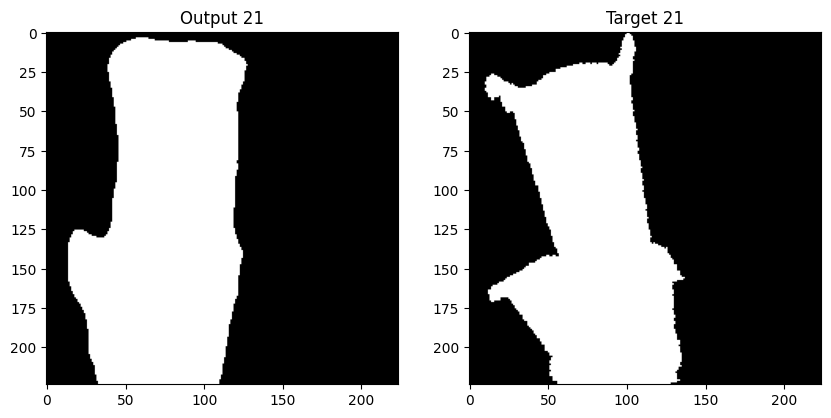

In [919]:
visualitza_resultats()